In [ ]:
# ===============================================================
# Yield Curve Climate Projection 
# ===============================================================
# Autore: Emanuele Migliaccio (2025) Marco Venditti (2025)
# Descrizione: Calibrazione del modello Nelson-Siegel
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pandas_datareader import data as web
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, minimize
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

In [3]:
# ---------------------------------------------------------------
# 1. Nelson–Siegel functions
# ---------------------------------------------------------------
def ns_loadings(tau, lamb):
    L2 = (1 - np.exp(-tau / lamb)) / (tau / lamb)
    L3 = L2 - np.exp(-tau / lamb)
    return L2, L3

def nelson_siegel(tau, b0, b1, b2, lamb):
    L2, L3 = ns_loadings(tau, lamb)
    return b0 + b1 * L2 + b2 * L3

In [32]:
#---------------------------------------------------------------
# 2. Historical calibration (US Treasury)
# ---------------------------------------------------------------
start, end = dt(2005, 1, 1), dt.today()
fred_tickers = ["DGS1MO","DGS3MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]
maturities_vec = np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30], float)

print("Scaricamento dati FRED (può richiedere qualche secondo)...")
yields = pd.concat([web.DataReader(t, "fred", start, end) for t in fred_tickers], axis=1)
yields.columns = fred_tickers
yields = yields.dropna(how="all").ffill() / 100.0
df_yields_annual = yields.resample("A").mean()

interp_curves = {}
for year, row in df_yields_annual.iterrows():
    mask = ~row.isna()
    if mask.sum() < 4:
        continue
    f = interp1d(maturities_vec[mask], row[mask].values, kind="cubic", fill_value="extrapolate")
    interp_curves[year.year] = f(maturities_vec)
df_interp = pd.DataFrame(interp_curves, index=maturities_vec).T

def ns_resid(c, x, y): 
    return y - nelson_siegel(x, *c)

ns_params = []
for year, row in df_interp.iterrows():
    y = row.values.astype(float)
    mask = ~np.isnan(y)
    x, y = maturities_vec[mask], y[mask]
    res = least_squares(ns_resid, [0.03,-0.02,0.02,1.5], args=(x,y), method="lm", max_nfev=10000)
    ns_params.append(dict(year=int(year), beta0=res.x[0], beta1=res.x[1], beta2=res.x[2], lambda_=abs(res.x[3])))
ns_params = pd.DataFrame(ns_params).sort_values("year").reset_index(drop=True)
print("Calibrazione NS completata.")

Scaricamento dati FRED (può richiedere qualche secondo)...
Calibrazione NS completata.


/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3916846770.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yields_annual = yields.resample("A").mean()
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:5: RuntimeWarning: overflow encountered in exp
  L2 = (1 - np.exp(-tau / lamb)) / (tau / lamb)
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:6: RuntimeWarning: overflow encountered in exp
  L3 = L2 - np.exp(-tau / lamb)
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:6: RuntimeWarning: invalid value encountered in subtract
  L3 = L2 - np.exp(-tau / lamb)


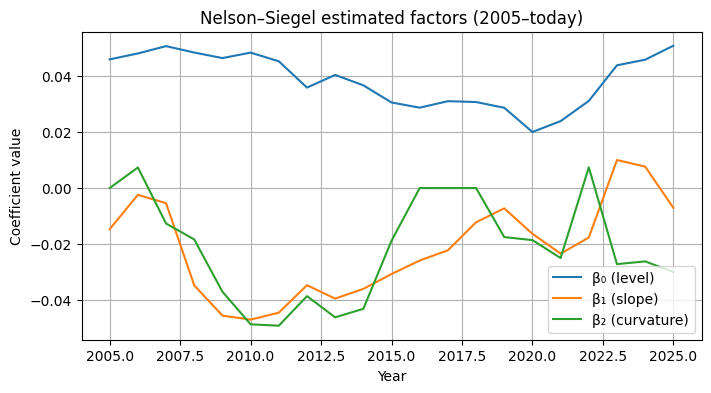

In [34]:
ns_params = pd.DataFrame(ns_params).sort_values("year").reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.plot(ns_params["year"], ns_params["beta0"], label="β₀ (level)")
plt.plot(ns_params["year"], ns_params["beta1"], label="β₁ (slope)")
plt.plot(ns_params["year"], ns_params["beta2"], label="β₂ (curvature)")
plt.title("Nelson–Siegel estimated factors (2005–today)")
plt.xlabel("Year"); plt.ylabel("Coefficient value"); plt.legend(); plt.grid(True); plt.show()

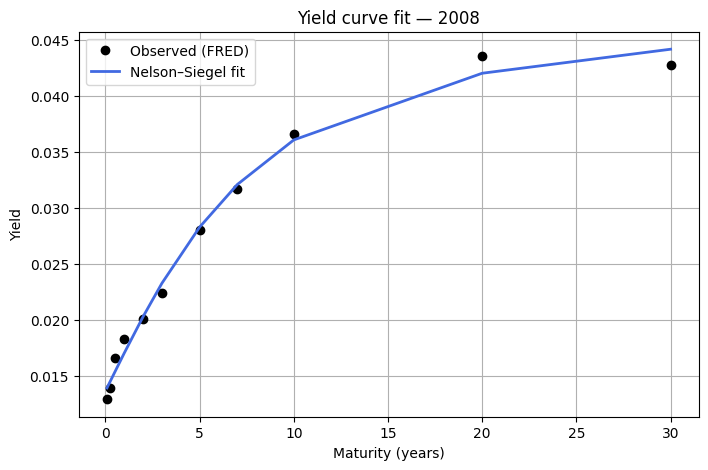

2008: RMSE = 0.000956


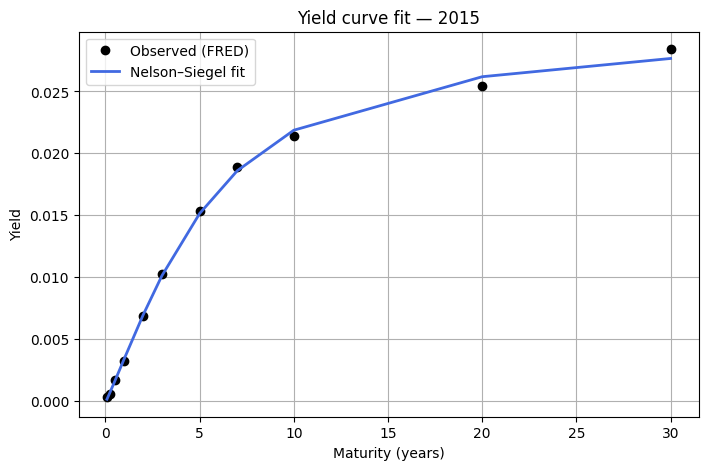

2015: RMSE = 0.000378


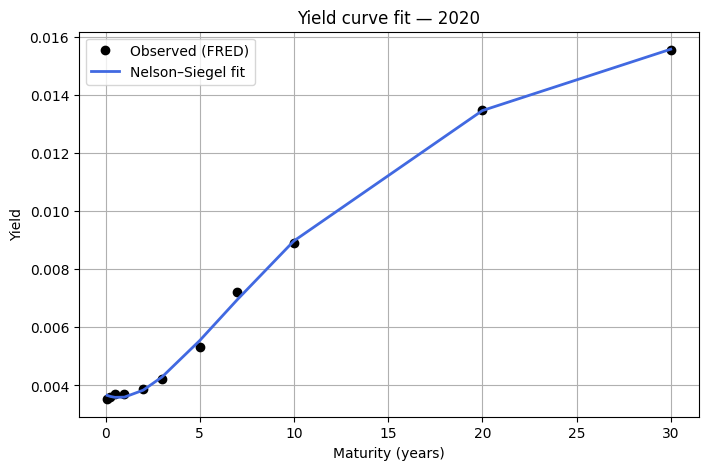

2020: RMSE = 0.000126


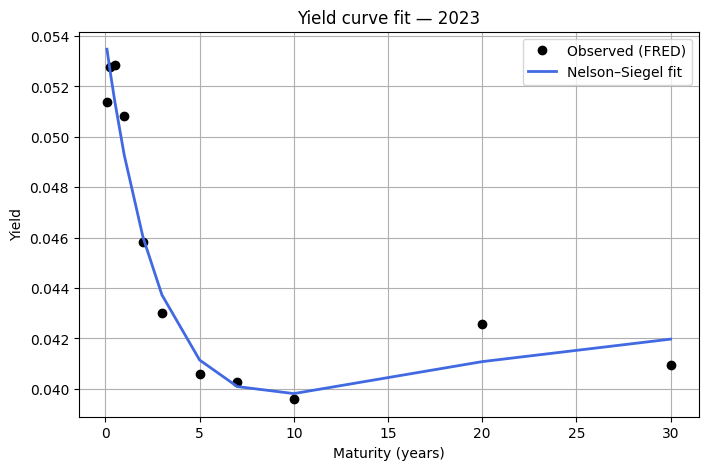

2023: RMSE = 0.001087


In [35]:
# --- 2b. Fit validation: observed vs NS-fitted yields ---
years_to_plot = [2008, 2015, 2020, 2023]
for year in years_to_plot:
    if year not in df_interp.index or year not in ns_params["year"].values:
        continue
    y_obs = df_interp.loc[year].values
    row = ns_params.loc[ns_params["year"] == year].iloc[0]
    y_fit = nelson_siegel(maturities_vec, row["beta0"], row["beta1"], row["beta2"], row["lambda_"])
    plt.figure(figsize=(8,5))
    plt.plot(maturities_vec, y_obs, "o", color="black", label="Observed (FRED)")
    plt.plot(maturities_vec, y_fit, "-", color="royalblue", lw=2, label="Nelson–Siegel fit")
    plt.title(f"Yield curve fit — {year}")
    plt.xlabel("Maturity (years)"); plt.ylabel("Yield"); plt.legend(); plt.grid(True); plt.show()
    rmse = np.sqrt(np.nanmean((y_obs - y_fit)**2))
    print(f"{year}: RMSE = {rmse:.6f}")



=== Ridge regression per beta0 ===
Alpha ottimale: 7.5646
GDP_std: -0.0016
Temperature_std: -0.0016
CO2 concentration_std: -0.0018


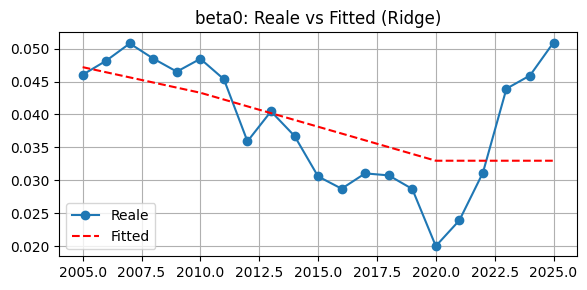


=== Ridge regression per beta1 ===
Alpha ottimale: 0.0107
GDP_std: 0.0608
Temperature_std: 0.0959
CO2 concentration_std: -0.1500


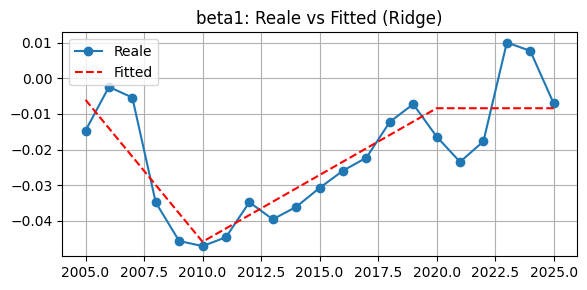


=== Ridge regression per beta2 ===
Alpha ottimale: 0.0061
GDP_std: 0.0647
Temperature_std: 0.1032
CO2 concentration_std: -0.1665


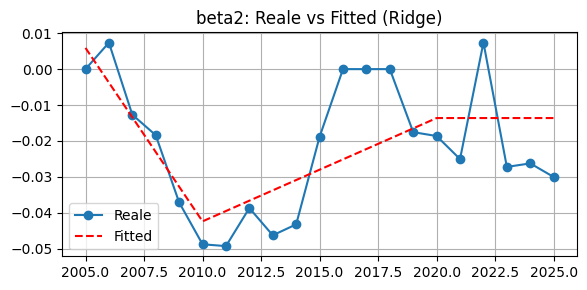


=== Ridge regression per lambda_ ===
Alpha ottimale: 123.2847
GDP_std: 0.0332
Temperature_std: 0.0329
CO2 concentration_std: 0.0348


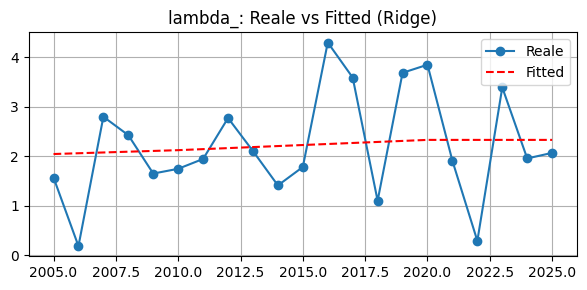

In [43]:


# 1. Carica dati IPCC
df_ipcc = pd.read_csv("/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv")
df_ipcc = df_ipcc[df_ipcc["Scenario"] == "SSP1 - 1.9"]
df_ipcc = df_ipcc[(df_ipcc["Year"] >= 2005) & (df_ipcc["Year"] <= 2025)]

# 2. Seleziona e interpola le variabili
vars_climate = ["GDP", "Temperature", "CO2 concentration"]
df_climate = df_ipcc[["Year"] + vars_climate].set_index("Year")
df_climate = df_climate.reindex(range(2005, 2026)).interpolate("linear").reset_index()

# 3. Standardizza
scaler = StandardScaler()
X_std = scaler.fit_transform(df_climate[vars_climate])
df_std = pd.DataFrame(X_std, columns=[v + "_std" for v in vars_climate])
df_climate = pd.concat([df_climate[["Year"]], df_std], axis=1)

# 4. Prepara NS params (assumendo che ns_params sia già definito)
ns_params["Year"] = ns_params["year"]
df_ns = ns_params[["Year", "beta0", "beta1", "beta2", "lambda_"]]

# 5. Merge
df_merged = pd.merge(df_ns, df_climate, on="Year")

# 6. Regressione Ridge + grafico
features = [v + "_std" for v in vars_climate]
alphas = np.logspace(-3, 3, 100)

def fit_ridge_and_plot(target):
    ridge = RidgeCV(alphas=alphas, cv=None).fit(df_merged[features], df_merged[target])
    print(f"\n=== Ridge regression per {target} ===")
    print(f"Alpha ottimale: {ridge.alpha_:.4f}")
    for coef, name in zip(ridge.coef_, features):
        print(f"{name}: {coef:.4f}")
    
    # Grafico
    plt.figure(figsize=(6, 3))
    plt.plot(df_merged["Year"], df_merged[target], "o-", label="Reale")
    plt.plot(df_merged["Year"], ridge.predict(df_merged[features]), "r--", label="Fitted")
    plt.title(f"{target}: Reale vs Fitted (Ridge)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return ridge

ridge_b0 = fit_ridge_and_plot("beta0")
ridge_b1 = fit_ridge_and_plot("beta1")
ridge_b2 = fit_ridge_and_plot("beta2")
ridge_l  = fit_ridge_and_plot("lambda_")


In [60]:

# Carica i dati IPCC
df_ipcc = pd.read_csv("/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv")

# Filtra scenario SSP1-1.9 e anni > 2025
df_future = df_ipcc[(df_ipcc["Scenario"] == "SSP1 - 1.9") & (df_ipcc["Year"] > 2025)]



In [61]:
# Seleziona e interpola variabili climatiche tra 2026–2100
df_future = df_future[["Year"] + vars_climate].copy()
df_future = df_future.set_index("Year")
df_future = df_future.reindex(range(2026, 2101))  # estendi l'indice anno
df_future = df_future.interpolate("linear")  # interpolazione temporale
df_future = df_future.reset_index()

In [62]:
# Rimuovi eventuali righe incomplete (se ci sono ancora NaN)
df_future_clean = df_future.dropna(subset=vars_climate)

In [63]:
# Standardizza con lo stesso scaler usato per il training
X_future_std = scaler.fit_transform(df_future_clean[vars_climate])
years_future = df_future_clean["Year"].values

In [64]:
# Predizione dei coefficienti NS
beta0_proj = ridge_b0.predict(X_future_std)
beta1_proj = ridge_b1.predict(X_future_std)
beta2_proj = ridge_b2.predict(X_future_std)
lambda_proj = ridge_l.predict(X_future_std)

# Costruisci DataFrame dei coefficienti NS proiettati
df_future_ns = pd.DataFrame({
    "Year": years_future,
    "beta0": beta0_proj,
    "beta1": beta1_proj,
    "beta2": beta2_proj,
    "lambda_": lambda_proj
})

/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


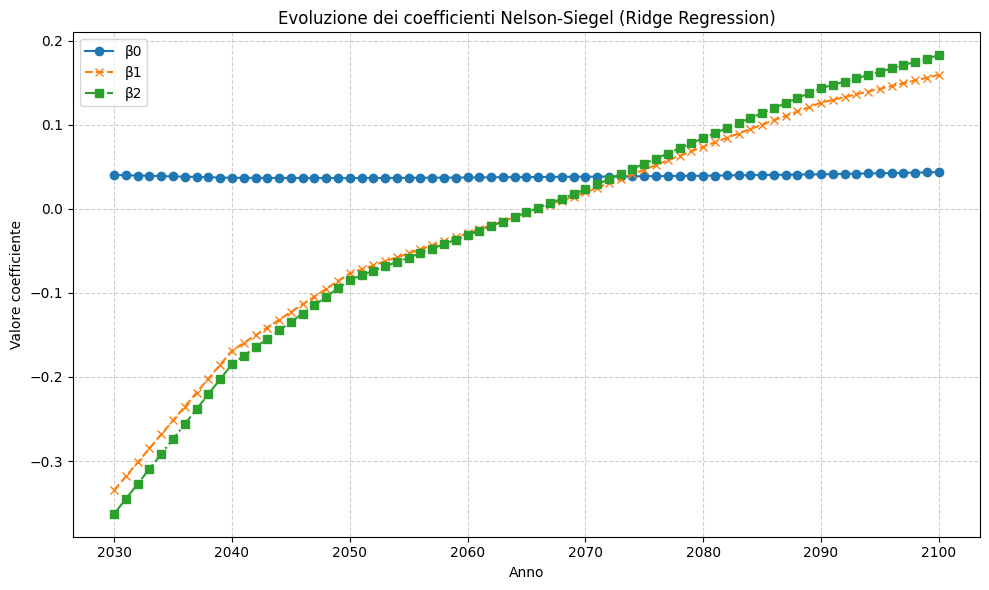

In [66]:

plt.figure(figsize=(10, 6))
plt.plot(df_future_ns["Year"], df_future_ns["beta0"], label="β0", linestyle='-', marker='o')
plt.plot(df_future_ns["Year"], df_future_ns["beta1"], label="β1", linestyle='--', marker='x')
plt.plot(df_future_ns["Year"], df_future_ns["beta2"], label="β2", linestyle='-.', marker='s')

plt.title("Evoluzione dei coefficienti Nelson-Siegel (Ridge Regression)")
plt.xlabel("Anno")
plt.ylabel("Valore coefficiente")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
